<a href="https://colab.research.google.com/github/eirikngard/GEO4902/blob/master/Data_assimilation_Eirik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Activate the following in colab : 
!pip3 install netCDF4
!apt install proj-bin libproj-dev libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
    
import xarray as xr

     |████████████████████████████████| 4.3MB 3.0MB/s 
     |████████████████████████████████| 296kB 35.6MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev libproj-dev proj-bin
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 305 kB of archives.
After this operation, 1,706 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 305 kB in 1s (394 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb .

Two forecasts: The second forecast is initialized 3 hours laters and has thus utilized forecast_1 as model background.

# Fill in the dates and hours for the exercise

In [94]:
year = '2018'; day = '24'; month = '10'
hour_1 = '00'; hour_2 = '06'

url='https://thredds.met.no/thredds/dodsC/aromearcticarchive/'+year+'/'+month+'/'+day+'/arome_arctic_full_2_5km_'+year+month+day+'T'+hour_1+'Z.nc'
forecast_1 = xr.open_dataset(url)

url='https://thredds.met.no/thredds/dodsC/aromearcticarchive/'+year+'/'+month+'/'+day+'/arome_arctic_full_2_5km_'+year+month+day+'T'+hour_2+'Z.nc'
forecast_2 = xr.open_dataset(url)

In [ ]:
forecast_1.air_temperature_ml

# Find a specific point and plot forecast

Note AROME Arctic is on an irregular grid

In [81]:
import math
import numpy as np

def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    latlon_idx = np.argmin(c)
    x, y = np.where(c == np.min(c))
    #print(alats[x,y],alon[x,y])
    x=int(x)
    y=int(y)
   
    return (x,y)

In [39]:
[ix,jx] = findindex(forecast_1.latitude,forecast_1.longitude,60.47,11.40) # Hamar

In [95]:
mlevel=64 #surfaece level
tml_point_forecast_1 = forecast_1.air_temperature_ml[:,64,ix,jx]
tml_point_forecast_2 = forecast_2.air_temperature_ml[:,64,ix,jx]

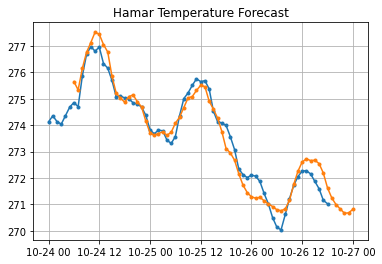

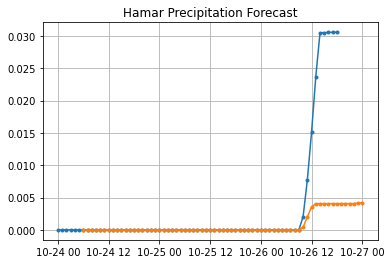

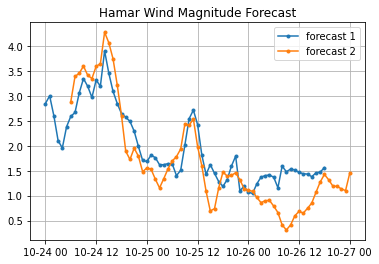

In [97]:
#Some plots

plt.plot(forecast_1.time, tml_point_forecast_1, '.-')
plt.plot(forecast_2.time, tml_point_forecast_2, '.-')
plt.title("Hamar Temperature Forecast"), plt.grid()
plt.show()

plt.plot(forecast_1.time, forecast_1.precipitation_amount_acc[:,0,ix,jx], '.-')
plt.plot(forecast_2.time, forecast_2.precipitation_amount_acc[:,0,ix,jx], '.-')
plt.title("Hamar Precipitation Forecast"), plt.grid()
plt.show()
wind1 = np.sqrt(np.array(forecast_1.y_wind_10m[:,0,ix,jx])**2+np.array(forecast_1.x_wind_10m[:,0,ix,jx])**2)
wind2 = np.sqrt(np.array(forecast_2.y_wind_10m[:,0,ix,jx])**2+np.array(forecast_2.x_wind_10m[:,0,ix,jx])**2)
plt.plot(forecast_1.time, wind1, '.-',label="forecast 1")
plt.plot(forecast_2.time, wind2, '.-', label="forecast 2")
plt.title("Hamar Wind Magnitude Forecast"), plt.legend(), plt.grid()
plt.show()

# Plot forecast on a map

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: The following kwargs were not used by contour: 'extemd'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: The following kwargs were not used by contour: 'extemd'


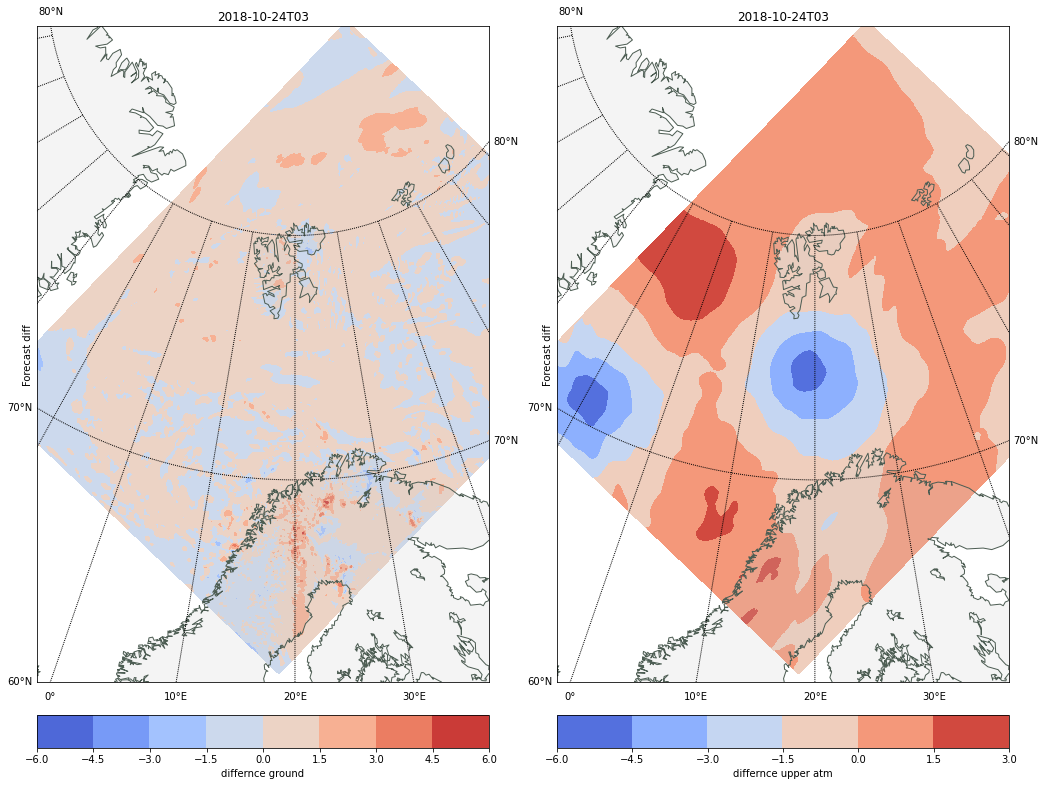

In [48]:
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec

timestep_1=3
timestep_2=0
mlevel = 64

fig = plt.figure(figsize=(15,15)) #11.7
plt.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0.05, wspace=0.15, hspace=0.05)
gs = gridspec.GridSpec(1, 2)

m = Basemap(projection='stere', 
            boundinglat=60, lon_0=20, lat_0=78.4, 
            resolution='l', 
            llcrnrlat= 60.0, urcrnrlat=82.0, llcrnrlon=-1.0, urcrnrlon=100.0)
 
ax = plt.subplot(gs[0],aspect='equal') 
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(np.array(forecast_1.longitude),np.array(forecast_1.latitude))               # compute map proj coordinates.
cs=m.contourf(x,y,np.array( forecast_1.air_temperature_ml[timestep_1,mlevel,:,:])- np.array(forecast_2.air_temperature_ml[timestep_2,mlevel,:,:]),cmap=plt.cm.coolwarm,extemd='max')
plt.title (np.datetime_as_string(forecast_1.time[timestep_1],unit='h'))
plt.ylabel("Forecast diff")
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('differnce ground')  

ax = plt.subplot(gs[1],aspect='equal') 
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(np.array(forecast_1.longitude),np.array(forecast_1.latitude))               # compute map proj coordinates.
cs=m.contourf(x,y,np.array( forecast_1.air_temperature_ml[timestep_1,0,:,:])- np.array(forecast_2.air_temperature_ml[timestep_2,0,:,:]),cmap=plt.cm.coolwarm,extemd='max')
plt.title (np.datetime_as_string(forecast_1.time[timestep_1],unit='h'))
plt.ylabel("Forecast diff")
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('differnce upper atm') 

Not very large differnces? No clear patterns for the ground level, very clear patterns for upper air level **(not sure what feature this is)**. High resolution compared to upper level. A generalt feature of the assimilation should be that it only captures large-scale patterns. 



## Analyse the impact of the data assimilation - Surface Model 

In [71]:
year =  '2020'; day  =  '15'; month = '09'; hour_1  ='00'; hour_2  ='03'

url='https://thredds.met.no/thredds/dodsC/aromearcticarchive/'+year+'/'+month+'/'+day+'/arome_arctic_sfx_2_5km_'+year+month+day+'T'+hour_1+'Z.nc'
forecast_1 = xr.open_dataset(url)
url='https://thredds.met.no/thredds/dodsC/aromearcticarchive/'+year+'/'+month+'/'+day+'/arome_arctic_sfx_2_5km_'+year+month+day+'T'+hour_2+'Z.nc'
forecast_2 = xr.open_dataset(url)

Point Forecast Hamar

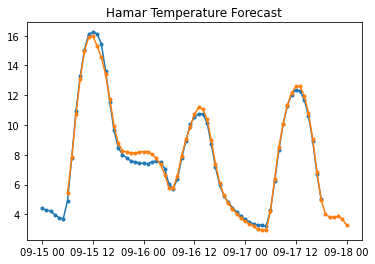

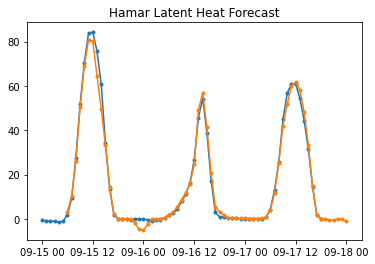

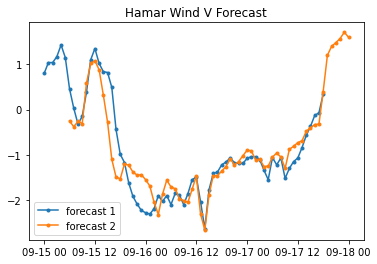

In [23]:
plt.plot(forecast_1.time, forecast_1.TS[:,ix,jx]-273, '.-')
plt.plot(forecast_2.time, forecast_2.TS[:,ix,jx]-273, '.-')
plt.title("Hamar Temperature Forecast")
plt.show()

plt.plot(forecast_1.time, forecast_1.LE[:,ix,jx], '.-')
plt.plot(forecast_2.time, forecast_2.LE[:,ix,jx], '.-')
plt.title("Hamar Latent Heat Forecast")
plt.show()

plt.plot(forecast_1.time, forecast_1.MER10M[:,ix,jx], '.-',label="forecast 1")
plt.plot(forecast_2.time, forecast_2.MER10M[:,ix,jx], '.-', label="forecast 2")
plt.title("Hamar Wind V Forecast"), plt.legend()
plt.show()

In [ ]:
forecast_1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'extemd'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: The following kwargs were not used by contour: 'extemd'


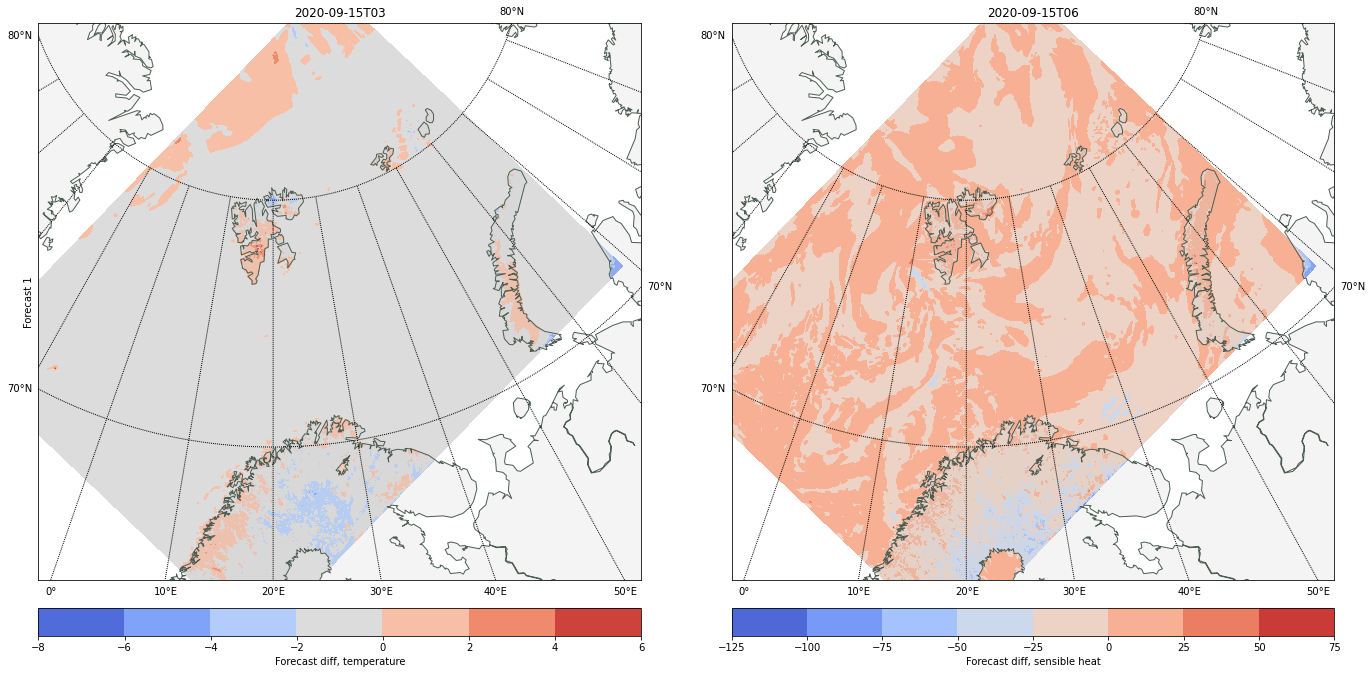

In [72]:
timestep_1=3
#timestep_2=0

fig = plt.figure(figsize=(20,20)) #11.7
plt.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0.05, wspace=0.15, hspace=0.05)
gs = gridspec.GridSpec(1, 2)

m = Basemap(projection='stere', 
            boundinglat=60, lon_0=20, lat_0=78.4, 
            resolution='l', 
            llcrnrlat= 63.0, urcrnrlat=75.0, llcrnrlon=-1.0, urcrnrlon=100.0)

ax = plt.subplot(gs[0],aspect='equal') 
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(np.array(forecast_1.longitude),np.array(forecast_1.latitude))               # compute map proj coordinates.
cs=m.contourf(x,y,np.array( forecast_1.TS[timestep_1,:,:])-np.array( forecast_2.TS[timestep_1,:,:]),cmap=plt.cm.coolwarm,extemd='max')
plt.title (np.datetime_as_string(forecast_1.time[timestep_1],unit='h'))
plt.ylabel("Forecast 1")
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('Forecast diff, temperature')  

ax = plt.subplot(gs[1],aspect='equal') 
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(np.array(forecast_2.longitude),np.array(forecast_2.latitude))               # compute map proj coordinates.
cs=m.contourf(x,y,np.array( forecast_1.H[timestep_1,:,:])-np.array( forecast_2.H[timestep_1,:,:]),cmap=plt.cm.coolwarm,extemd='max')
plt.title (np.datetime_as_string(forecast_2.time[timestep_1],unit='h'))
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('Forecast diff, sensible heat')  

Magnitude of the change is larger for temeprature now. Negative values indicates higher values in second forecast. I looks like the first forecast/bakground is underestimating the values over land, and overestimating them over water. Also, there are no "ground" asimialtion over water in the surface model. 

## Single observation data assimilation experiment 

Load BACKGROUND fields of temperature, wind and specific humidity


In [49]:
url='https://thredds.met.no/thredds/dodsC/metusers/maltem/GEO4902_2020/remap.varn.BG.nc'
model_background = xr.open_dataset(url)

# Load ANALYSIS fields of temperature,wind, and specific humidity
This analysis has been produced by assimilating a radiosonde information at 500hPa

In [50]:
url='https://thredds.met.no/thredds/dodsC/metusers/maltem/GEO4902_2020/remap.varn.LPB_POS2_TEMP500.nc'
model_analysis = xr.open_dataset(url)

The data is stored in the original coordinates of the model, but do not worry about that. Just assume it is some kind of vertical discretization. Remember that you can look in the metadata to find the variable names and coordinate information!

# Below are two plotting routines which yo can use to plot horizontal and vertical sections of the model.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'extemd'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: The following kwargs were not used by contour: 'extemd'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: The following kwargs were not used by contour: 'extemd'


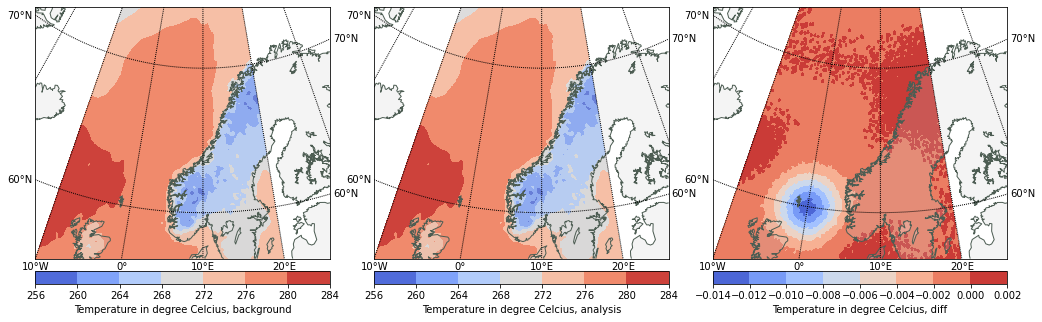

In [64]:
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

timestep=0; modellevel=59
temp_background = model_background.air_temperature[timestep,modellevel,:,:]
temp_analysis   = model_analysis.air_temperature[timestep,modellevel,:,:]

fig = plt.figure(figsize=(15,15)) #11.7
gs = gridspec.GridSpec(1,3)
plt.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0.05, wspace=0.15, hspace=0.05)
ax = plt.subplot(111)
m = Basemap(projection='stere', 
            boundinglat=40, lon_0=10, lat_0=78.4, 
            resolution='l', 
            llcrnrlat= 55.0, urcrnrlat=72.0, llcrnrlon=-10.0, urcrnrlon=40.0)

ax = plt.subplot(gs[0],aspect='equal')  
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(*np.meshgrid(model_background.lon,model_background.lat))
cs=m.contourf(x,y,temp_background,cmap=plt.cm.coolwarm,extemd='max')
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('Temperature in degree Celcius, background') 

ax = plt.subplot(gs[1],aspect='equal')  
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(*np.meshgrid(model_analysis.lon,model_background.lat))
cs=m.contourf(x,y,temp_analysis,cmap=plt.cm.coolwarm,extemd='max')
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('Temperature in degree Celcius, analysis') 

ax = plt.subplot(gs[2],aspect='equal')  
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(*np.meshgrid(model_background.lon,model_background.lat))
cs=m.contourf(x,y,temp_analysis-temp_background,cmap=plt.cm.coolwarm,extemd='max')
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('Temperature in degree Celcius, diff') 

I guess this is the point where the radiosonde is assimialted? at 500hPa
The background and the analysis looks identical.
What is the "cross" feature of the radiosonde assimialtion? 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The following kwargs were not used by contour: 'extemd'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: The following kwargs were not used by contour: 'extemd'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: The following kwargs were not used by contour: 'extemd'


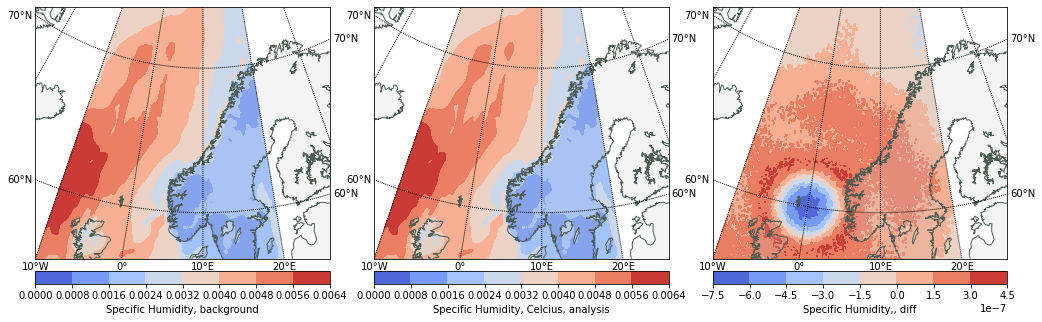

In [67]:
timestep=0; modellevel=59
temp_background = model_background.specific_humidity[timestep,modellevel,:,:]
temp_analysis   = model_analysis.specific_humidity[timestep,modellevel,:,:]

fig = plt.figure(figsize=(15,15)) #11.7
gs = gridspec.GridSpec(1,3)
plt.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0.05, wspace=0.15, hspace=0.05)
ax = plt.subplot(111)
m = Basemap(projection='stere', 
            boundinglat=40, lon_0=10, lat_0=78.4, 
            resolution='l', 
            llcrnrlat= 55.0, urcrnrlat=72.0, llcrnrlon=-10.0, urcrnrlon=40.0)

ax = plt.subplot(gs[0],aspect='equal')  
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(*np.meshgrid(model_background.lon,model_background.lat))
cs=m.contourf(x,y,temp_background,cmap=plt.cm.coolwarm,extemd='max')
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('Specific Humidity, background') 

ax = plt.subplot(gs[1],aspect='equal')  
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(*np.meshgrid(model_analysis.lon,model_background.lat))
cs=m.contourf(x,y,temp_analysis,cmap=plt.cm.coolwarm,extemd='max')
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('Specific Humidity, Celcius, analysis') 

ax = plt.subplot(gs[2],aspect='equal')  
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(*np.meshgrid(model_background.lon,model_background.lat))
cs=m.contourf(x,y,temp_analysis-temp_background,cmap=plt.cm.coolwarm,extemd='max')
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('Specific Humidity,, diff') 

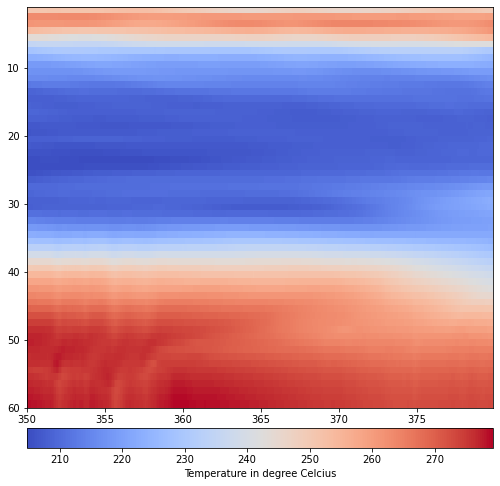

In [78]:
fig = plt.figure(figsize=(7.2,7.2)) #11.7
plt.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0.05, wspace=0.15, hspace=0.05)
ax = plt.subplot(111)


timestep=0; seclat=1; # Intersection at latitude model_analysis.lat[seclat]

tempvert_background =  np.array(model_background.air_temperature[timestep,:,seclat,:])
tempvert_analysis   =  np.array(model_analysis.air_temperature[timestep,:,seclat,:])

windvert_background=np.sqrt(np.array(model_background.x_wind[timestep,:,seclat,:]**2+model_background.y_wind[timestep,:,seclat,:]**2))
windvert_analysis  =np.sqrt(np.array(model_analysis.x_wind[timestep,:,seclat,:])**2+np.array(model_analysis.y_wind[timestep,:,seclat,:])**2)

humidvert_background =  np.array(model_background.specific_humidity[timestep,:,seclat,:])
humidvert_analysis   =  np.array(model_analysis.specific_humidity[timestep,:,seclat,:])

cs=ax.pcolor(model_background.lat, range(1,61),tempvert_background, cmap=plt.cm.coolwarm)


plt.gca().invert_yaxis()
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('Temperature in degree Celcius')   
#fig.colorbar(c, ax=ax1)
